In [1]:
from warnings import filterwarnings

import numpy as np
import torch, pyro

from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_orig()

# noinspection PyUnresolvedReferences
from clipppy.patches import torch_numpy
torch.set_default_tensor_type(torch.cuda.FloatTensor)

filterwarnings('ignore', module='torch.nn.modules.lazy')
filterwarnings('ignore', message='Named tensors')
filterwarnings('ignore', module='pytorch_lightning.trainer.data_loading',
               message='The dataloader, train_dataloader, does not have many workers')

In [2]:
from libsimplesn import SimpleSN

simplesn = SimpleSN(survey='pantheon-g10', datatype='specz', N=100_000, suffix=0)
config = simplesn.config(gen=True)
nre = config.lightning_nre

#### Define network

In [3]:
from torch import nn

from clipppy.commands.nre import MultiNRETail, WhiteningHead, UWhiteningTail
from clipppy.utils.nn import mlp, omlp, USequential, Movedim, LazyBatchedConv1d, WhitenOnline


convlayer = lambda out_channels, kernel_size, **kwargs: nn.Sequential(
    LazyBatchedConv1d(
        out_channels=out_channels, groups=1,
        kernel_size=kernel_size, stride=kernel_size),
    WhitenOnline(ndim=2), nn.ReLU()
)


hp = {
    'structure': {
        'head': {
            'nlayers': 3,
            'size': 128,
            'osize': 32
        }
    },
    'training': {
        'batch_size': 64,
        'lr': 1e-4
    }
}


# summary = lambda: nn.Sequential(convlayer(32, 100), convlayer(32, 30), nn.Flatten(-2))


nre.head = WhiteningHead(head=USequential(
    nn.Unflatten(-1, (-1, 3)),
    mlp(128, 128, 128, 32),
    Movedim(source=-1, destination=-2),
), event_dims={'data': 2})
nre.tail = MultiNRETail(tails={
    ('Om0', 'Ode0'): UWhiteningTail(
        thead=mlp(256, 256),
        xhead=nn.Sequential(nn.Flatten(-2), nn.Dropout(0.999), mlp(256)),
#         xhead=nn.Sequential(
#             convlayer(32, 100), nn.Flatten(-2), mlp(256)
#         ),
        net=omlp(256, 256, 256)),
#     'sigma_z': UWhiteningTail(
#         thead=mlp(128, 128), xhead=summary(),
#         net=omlp(128, 128, 128)),
#     'mean_M0': UWhiteningTail(
#         thead=mlp(128, 128), xhead=summary(),
#         net=omlp(128, 128, 128)),
#     'sigma_res': UWhiteningTail(
#         thead=mlp(128, 128), xhead=summary(),
#         net=omlp(128, 128, 128)),
#     'alpha': UWhiteningTail(
#         thead=mlp(128, 128), xhead=summary(),
#         net=omlp(128, 128, 128)),
#     'beta': UWhiteningTail(
#         thead=mlp(128, 128), xhead=summary(),
#         net=omlp(128, 128, 128))
})


MAX_BATCH = 32
STRUCTURE_NAME = 'zoom-3-all/onlycosmo-fc'

## Inferring $M_0^s$

In [ ]:
# @attr.s(auto_attribs=True, eq=False)
# class IUWhiteningTail(WhiteningTail):
#     summary: nn.Module = attr.ib(default=_empty_module)

#     def forward(self, theta: torch.Tensor, x: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
#         return self.net(broadcast_cat((
#             torch.linspace(-1, 1, theta.shape[-1])[:, None],
#             self.thead(theta),
#             x[0].unflatten(-1, (-1, 3)),
#             self.summary(x[1]).unsqueeze(-2)
#         ), -1)).squeeze(-1)

#     'M0': IUWhiteningTail(
#         thead=nn.Unflatten(-1, (-1, 1)),
#         summary=nn.Sequential(*layers(256, 256, 4)),
#         net=nn.Sequential(*layers(128, 128, 128), nn.LazyLinear(1))
#     ),

In [ ]:
from clipppy.utils.messengers import CollectSitesMessenger
from clipppy.stochastic import find_sampler


with CollectSitesMessenger('M0') as prior_samples, pyro.plate('plate', 10000):
    find_sampler(config._model, 'M0')()

In [ ]:
trace = {
    key: val.detach() if torch.is_tensor(val) else val
    for key, val in pyro.condition(config.mock, data={
        'mean_x1': 0, 'log10_R_x1': 0,
        'mean_c': 0, 'log10_R_c': -1,
        'mean_M0': torch.tensor(-19.7),
#         'sigma_res': torch.tensor(0.1),
        'zobs': config.kwargs['defs']['zcmb']
    })(initting=True, conditioning=False).nodes.items() for val in [val['value']]
}

obs = {key: trace[key].unsqueeze(-2) for key in nre.obs_names}

nre.head.eval(), nre.tail.eval()
with torch.no_grad():
    ratios = torch.cat([nre.tail(*nre.head({'M0': val}, obs))[0].exp_() for val in prior_samples['M0'].split(100, dim=0)], 0)
weights = ratios / ratios.sum(0)

post_mean = (weights * prior_samples['M0']).sum(0)
post_std = ((weights * prior_samples['M0']**2).sum(0) - post_mean**2)**0.5

In [ ]:
plt.hist(post_std.numpy())

In [ ]:
plt.axhline(0)
plt.errorbar(
    trace['M0'], post_mean - trace['M0'], post_std, ls='none',
    capsize=2, capthick=1, elinewidth=1, marker='.', ms=2.6);

In [ ]:
with CollectSitesMessenger('M0') as sites, pyro.plate('plate', 10000):
    find_sampler(config._model, 'M0')()
plt.hist(sites['M0'][..., 0].numpy(), bins=100, alpha=0.5, density=True);

with CollectSitesMessenger('M0') as sites, pyro.plate('plate', 10000):
    config.mock()
plt.hist(sites['M0'][..., 0].numpy(), bins=100, alpha=0.5, density=True);

with CollectSitesMessenger('M0') as sites, pyro.plate('plate', 10000):
    config.mock(initting=False)
plt.hist(sites['M0'][..., 0].numpy(), bins=100, alpha=0.5, density=True);

## Inferring global parameters

In [4]:
zoom_levels = [
    {'Om0': [0, 2], 'Ode0': [0, 2]},
    {'Om0': [0, 0.7], 'Ode0': [0.3, 1.2]},
    {'Om0': [0.2, 0.5], 'Ode0': [0.5, 1]},
    {'Om0': [0.25, 0.35], 'Ode0': [0.6, 0.8]}
]
ZOOM_LEVEL = zoom_levels[3]

nre.dataset_config.kwargs['ranges'].update(ZOOM_LEVEL | {
    'alpha': [0.1, 0.2],
    'beta': [2.5, 3.5],
    'mean_M0': [-19.7, -19.3],
    'sigma_res': [1e-3, 0.3],
    'sigma_z': [0.03, 0.05]
})
config.kwargs['defs']['priors'].update({
    key: pyro.distributions.Uniform(*val)
    for key, val in ZOOM_LEVEL.items()
})

In [5]:
from collections import defaultdict

from clipppy.commands.nre.validate import MultiNREValidator, MultiNRECoverage
from clipppy.utils.plotting.nre import MultiNREPlotter


cdataset = nre.dataset.dataset

def nrepper(ngrid):
    return MultiNREPlotter(
        groups=nre.tail.tails.keys(),
        ranges={**{
            'Om0': (0, 2), 'Ode0': (0, 2),
            'sigma_res': (1e-3, 1.),
            'sigma_z': (1e-3, 0.2),
            'mean_M0': (-20, -19),
            'alpha': (0, 1),
            'beta': (0, 4)
        }, **cdataset.ranges},
        grid_sizes=defaultdict(lambda: 256, Om0=ngrid, Ode0=ngrid),
        priors=config.kwargs['defs']['priors'],
        labels={
            'Om0': r'$\Omega_{m, 0}$',
            'Ode0': r'$\Omega_{\Lambda, 0}$',
            'sigma_z': r'$\sigma_z$',
            'sigma_res': r'$\sigma_{\mathrm{res}}$',
            'mean_M0': r'$M_0$',
            'alpha': r'$\alpha$',
            'beta': r'$\beta$'
        }
    )

nrep = nrepper(32)
validator = MultiNREValidator(nre, nrep, 1024//MAX_BATCH, MAX_BATCH)

trace = {
    key: val.detach() if torch.is_tensor(val) else val
    for key, val in simplesn.trace.nodes.items()
    for val in [val['value']]
}

#### Train

In [6]:
hparams_ = {
    'batch_size': [16, 64],
    'lowlr': [1e-4], 'highlr': [1e-3],
    'lrsched': ['lowlr', 'highlr', 'onecycle']
}

nre.just_save_hyperparameters(hp['training'])
HPARAMS_NAME = 'step'

In [7]:
import os

import clipppy.commands.lightning.config.schedulers as lrs
from clipppy.commands.lightning.callbacks import MultiPosteriorCallback, MultiValidationCallback
from clipppy.commands.lightning.patches import TensorBoardLogger, Trainer, ModelCheckpoint, LearningRateMonitor


CHECKPOINT_EVERY = 500


name = os.path.join(simplesn.data_prefix, STRUCTURE_NAME, HPARAMS_NAME)

assert (nre.hparams['batch_size'] < MAX_BATCH
        or not nre.hparams['batch_size'] % MAX_BATCH)
batch_size = min(nre.hparams['batch_size'], MAX_BATCH)
accumulate_grad_batches = nre.hparams['batch_size'] // batch_size

print(f'Memory batch size: {batch_size}')
print(f'Accumulating: {accumulate_grad_batches} -> {batch_size * accumulate_grad_batches} ({nre.hparams["batch_size"]} requested)')

nre.lr = nre.hparams['lr']
nre.dataset_config.kwargs['batch_size'] = batch_size

# n_steps = 20000
# nre.scheduler_config = OneCycleLR(
#     max_lr=1e-3, total_steps=n_steps, pct_start=0.15,
#     div_factor=10, final_div_factor=1,
#     three_phase=False,
# )
# nre.scheduler_config = CyclicLR(
#     1e-4, 1e-3, mode='triangular2',
#     cycle_momentum=False
# )
if 'step' in HPARAMS_NAME:
    nre.scheduler_config = lrs.StepLR(step_size=2000, gamma=0.5)

version = 0
ckpt_path = None
# ckpt_path = f'lightning_logs/{name}/version_{version}/checkpoints/epoch=0-step=4999.ckpt'

trainer = Trainer(
    gpus=1, max_epochs=-1,
    max_steps=10000,
    logger=TensorBoardLogger('lightning_logs', name, version=version if ckpt_path else None),
    callbacks=[
        MultiValidationCallback(CHECKPOINT_EVERY, validator),
        MultiPosteriorCallback(CHECKPOINT_EVERY, nre, nrep, trace),
        LearningRateMonitor(),
        ModelCheckpoint(every_n_train_steps=CHECKPOINT_EVERY)
    ],
    accumulate_grad_batches=accumulate_grad_batches
)
trainer.fit(nre, nre.training_loader, ckpt_path=ckpt_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Memory batch size: 32
Accumulating: 2 -> 64 (64 requested)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

## Results

In [6]:
# LOGDIR = 'lightning_logs/pantheon-g10-100000-0-photoz/onlycosmo/lowlr/version_2'
LOGDIR = f'lightning_logs/pantheon-g10-100000-0-specz/zoom-3-all/onlycosmo-fc/step/version_1'
NSTEPS = 9999
ckpt = torch.load(f'{LOGDIR}/checkpoints/epoch=0-step={NSTEPS}.ckpt')

nre.head, nre.tail = ckpt['clipppy_nets']
LOGDIR

'lightning_logs/pantheon-g10-100000-0-specz/zoom-3-all/onlycosmo-fc/step/version_1'

In [7]:
nre = nre.cuda().eval()

### Coverage

In [ ]:
coverage = MultiNRECoverage(nre, nrepper(32), 1024//MAX_BATCH, MAX_BATCH)
coverages = {
    group: coverage.confidence(group)
    for group in coverage.nrep.plotters.keys()
}

In [10]:
torch.save(coverages, f'{LOGDIR}/coverage-{NSTEPS}.pt')

In [5]:
coverages = torch.load(f'{LOGDIR}/coverage-{NSTEPS}.pt')

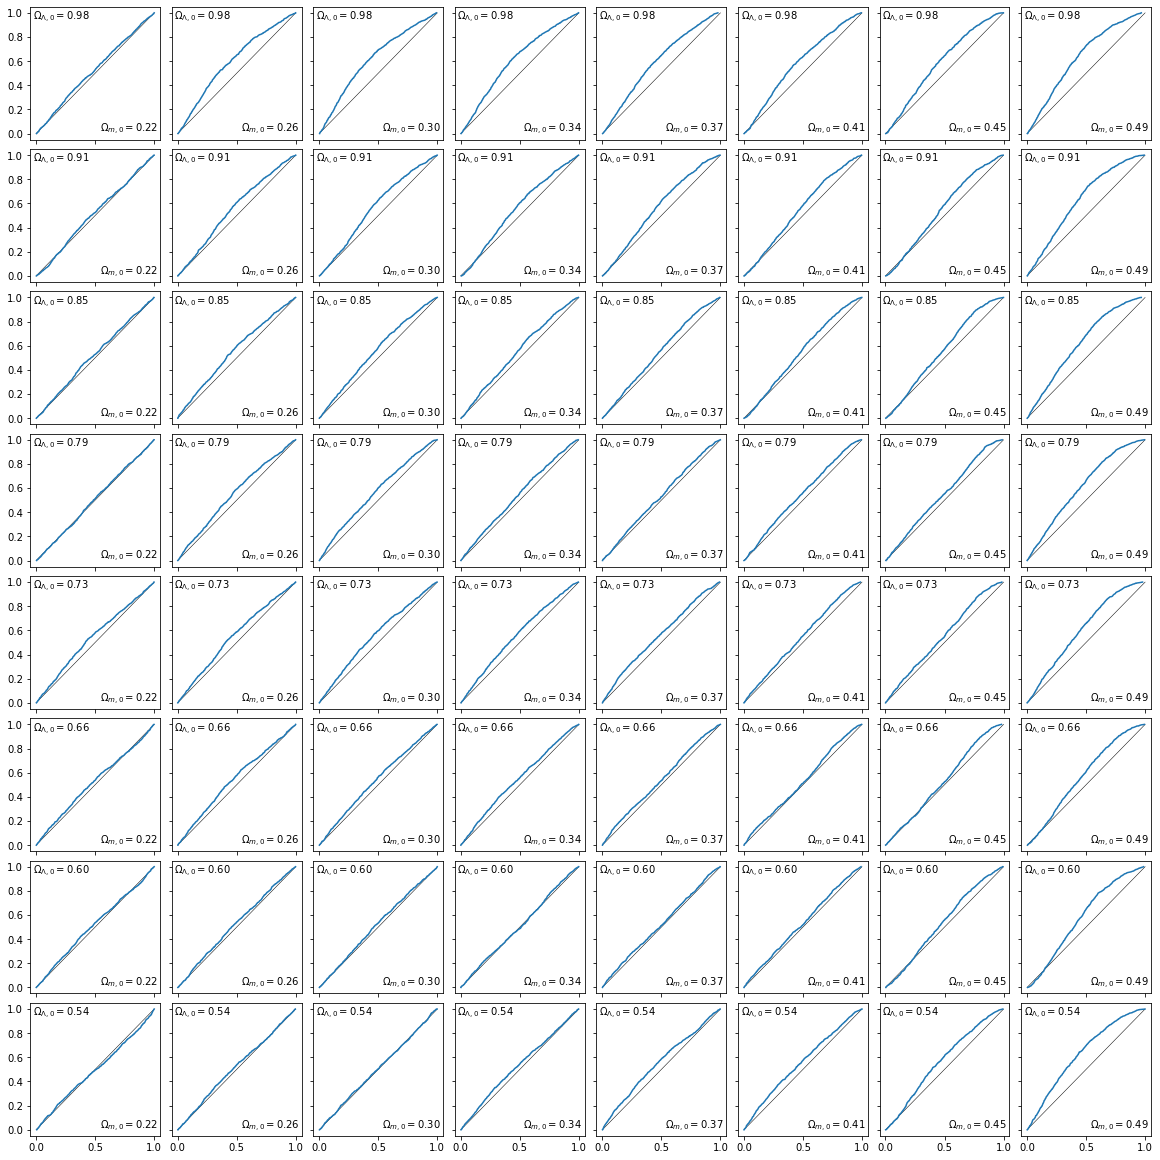

In [14]:
import pandas as pd

colmask = slice(2, None, 4)
plotter = coverage.nrep.plotters[group]

covdf = pd.DataFrame(
    coverages[group].flatten(end_dim=-2).sort(-1).values,
    index=pd.MultiIndex.from_arrays(
        list(map(torch.Tensor.tolist, plotter.grid.values())),
        names=plotter.grid.keys())
)

figure, axs = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(16, 16))

for ax, (key, c) in zip(
    axs[::-1].T.flatten(), covdf.iloc[
        np.arange(plotter.grid_shape.numel()).reshape(plotter.grid_shape)[colmask, colmask].flatten()
    ].iterrows()
):
    ax.plot(*2*((0, 1),), lw=0.5, color='k')
    ax.plot(c, np.linspace(0, 1, len(c)))
    
    lbls = [f'${plotter._param_label(k).strip("$")} = {v:.2f}$' for k, v in zip(covdf.index.names, key)]
    
    ax.text(0.98, 0.02, lbls[0], transform=ax.transAxes, va='bottom', ha='right')
    ax.text(0.02, 0.98, lbls[1], transform=ax.transAxes, va='top', ha='left')

Text(0, 0.5, '$\\Omega_{\\Lambda, 0}$')

posx and posy should be finite values


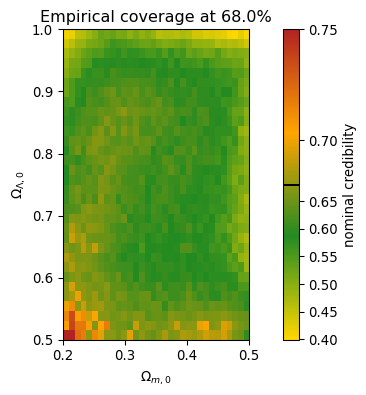

In [13]:
P = 0.68

group = 'Om0', 'Ode0'
plotter = nrep.plotters[group]

plt.figure(dpi=96)

plt.imshow(
    torch.quantile(coverages[group], P, -1),
    extent=(*coverage.nrep.ranges[group[0]],
            *coverage.nrep.ranges[group[1]]), origin='lower',
#     vmin=P-0.1, vmax=P+0.1,
    norm=plt.matplotlib.colors.TwoSlopeNorm(P),
    cmap=plt.matplotlib.colors.LinearSegmentedColormap.from_list(
        'traffic?', ('gold', 'forestgreen', 'orange', 'firebrick')
    )
)
cax = plt.colorbar()
cax.set_label('nominal credibility')
cax.ax.axhline(P, color='k')

plt.title(f'Empirical coverage at {P:.1%}')
plt.xlabel(plotter._param_label(group[0]))
plt.ylabel(plotter._param_label(group[1]))

### Validation

  0%|          | 0/128 [00:00<?, ?it/s]

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

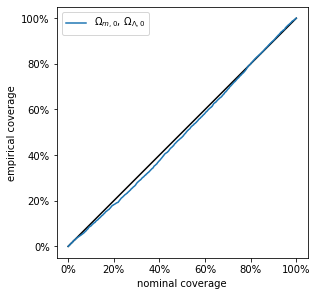

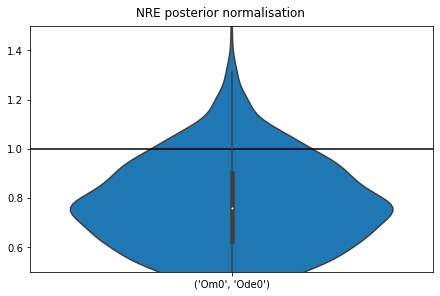

In [11]:
MultiNREValidator(nre, nrepper(128), 4096//MAX_BATCH, MAX_BATCH)()

### Corner

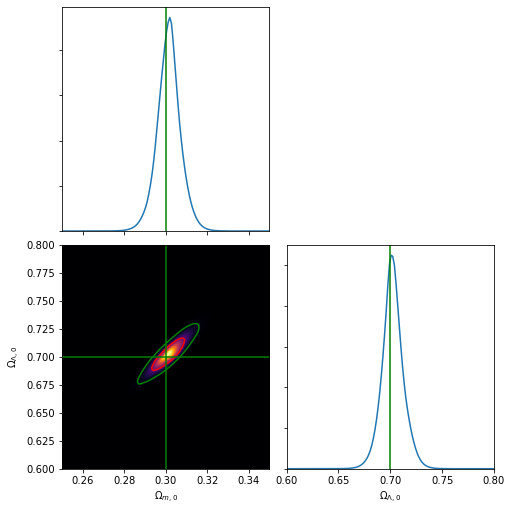

In [8]:
from clipppy.commands.lightning.callbacks import multi_posterior


random_trace = {
    key: val.detach() if torch.is_tensor(val) else val
    for key, val in pyro.condition(config.mock, data={
        'mean_x1': 0, 'log10_R_x1': 0,
        'mean_c': 0, 'log10_R_c': -1,
        # 'sigma_z': torch.distributions.Uniform(0, 0.2).sample(),
        # 'mean_M0': torch.distributions.Uniform(-20., -19.).sample(),
        # 'sigma_res': torch.distributions.Uniform(0, 0.2).sample(),
        'Om0': torch.tensor(0.3), 'Ode0': torch.tensor(0.7),
        'sigma_z': torch.tensor(0.04),
        'mean_M0': torch.tensor(-19.7),
        'sigma_res': torch.tensor(0.1),
        'alpha': torch.tensor(0.14), 'beta': torch.tensor(3.1),
    })(initting=False, conditioning=False).nodes.items() for val in [val['value']]
}

multi_posterior(nre, nrepper(128), trace);

### Compare MC

In [13]:
# from operator import itemgetter
# mcmc = simplesn.hmc_result
# Om0, Ode0 = map(torch.Tensor.numpy, itemgetter('Om0', 'Ode0')(mcmc.get_samples(2000)))

In [16]:
simplesn.suffix = 0

In [17]:
from operator import itemgetter
import arviz as az


idata = simplesn.emcee_result.to_dataset()
# def plot_trace(trace): return
# mc = torch.load(simplesn.resdir / f'{simplesn.data_prefix}-emcee.pt')

# idata = az.convert_to_inference_data(mc.constrain(mc.get_batched_params(mc.chain)))['posterior']

Om0, Ode0 = (
    a.to_numpy().flatten()
    for a in itemgetter('Om0', 'Ode0')(idata[{'draw': slice(200, None)}])
)

In [18]:
from scipy.stats import gaussian_kde

kde = gaussian_kde((Om0, Ode0))((Om0, Ode0))
asort = np.argsort(kde)
Om0, Ode0 = Om0[asort], Ode0[asort]

In [48]:
random_trace = {
    key: val.detach() if torch.is_tensor(val) else val
    for key, val in pyro.condition(config.mock, data={
        'mean_x1': 0, 'log10_R_x1': 0,
        'mean_c': 0, 'log10_R_c': -1,
        # 'sigma_z': torch.distributions.Uniform(0, 0.2).sample(),
        # 'mean_M0': torch.distributions.Uniform(-20., -19.).sample(),
        # 'sigma_res': torch.distributions.Uniform(0, 0.2).sample(),
        'Om0': torch.tensor(0.3), 'Ode0': torch.tensor(0.7),
        'sigma_z': torch.tensor(0.04),
        'mean_M0': torch.tensor(-19.5),
        'sigma_res': torch.tensor(0.1),
        'alpha': torch.tensor(0.14), 'beta': torch.tensor(3.1),
    })(initting=False, conditioning=False).nodes.items() for val in [val['value']]
}

In [50]:
random_trace

{'zobs': tensor([0.3080, 0.0146, 0.5892,  ..., 0.0462, 0.2427, 0.9212]),
 'z': tensor([0.3080, 0.0146, 0.5892,  ..., 0.0462, 0.2427, 0.9212]),
 'Om0': tensor(0.3000),
 'Ode0': tensor(0.7000),
 'alpha': tensor(0.1400),
 'beta': tensor(3.1000),
 'mean_M0': tensor(-19.5000),
 'sigma_res': tensor(0.1000),
 'M0': tensor([-19.5459, -19.6732, -19.5647,  ..., -19.3978, -19.3976, -19.3033]),
 'mean_x1': 0,
 'log10_R_x1': 0,
 'x1': tensor([-1.7506,  0.0512,  1.6318,  ...,  0.0227,  0.9468, -0.9333]),
 'mean_c': 0,
 'log10_R_c': -1,
 'c': tensor([ 0.0280,  0.0489,  0.0550,  ..., -0.0021, -0.0085,  0.1234]),
 'M': tensor([-19.2140, -19.5286, -19.6227,  ..., -19.4074, -19.5564, -18.7901]),
 'm': tensor([21.0330, 13.6970, 22.2939,  ..., 16.3751, 20.0979, 24.3153]),
 'data': tensor([[ 2.1023e+01, -1.5286e+00,  3.9880e-02],
         [ 1.3682e+01,  3.5477e-02,  8.4802e-02],
         [ 2.2279e+01,  1.3885e+00,  8.6473e-02],
         ...,
         [ 1.6403e+01,  2.0740e-01, -2.1355e-02],
         [ 2.015

Text(0.5, 0.98, 'pantheon-g10-100000-0-specz')

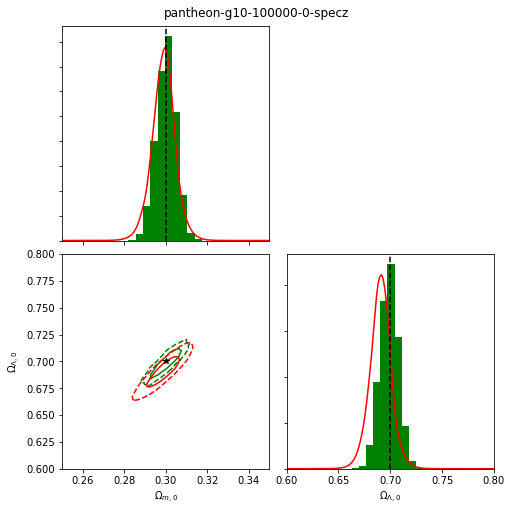

In [49]:
from importlib import reload
import clipppy.utils.plotting.posterior
reload(clipppy.utils.plotting.posterior)
from clipppy.utils.plotting.posterior import FuncPosteriorPlotter


# trace = simplesn.data
trace = SimpleSN(simplesn.survey, simplesn.N, 1, 'specz').data
obs = {key: random_trace[key] for key in nre.obs_names}

plotter = FuncPosteriorPlotter()
plotter.corner_names = 'Om0', 'Ode0'
plotter.labels = nrep.labels
plotter.ranges = nrep.ranges

key = ('Om0', 'Ode0')
levels = (0.68, 0.95)

fig, axs = plotter._corner_figure()

axs[1, 0].tricontour(
    Om0, Ode0, np.linspace(1, 0, len(kde)), levels=levels,
    colors='green', linestyles=('-', '--')
)
axs[0, 0].hist(Om0, density=True, color='green')
axs[1, 1].hist(Ode0, density=True, color='green')

plotter.default_truth_color = 'k'

_nrep = nrepper(128)
plotter.corner(
    _nrep.grids, _nrep.plotters[key].post(obs, nre.head, _nrep.subtails(nre.tail)[key]),
    fig=fig, truths=trace, plot_dist=False,
    contour_kwargs={'colors': 'red', 'levels': levels},
    line1d_kwargs={'color': 'red'}
)

plt.suptitle(simplesn.data_prefix)